In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sc
from scipy.optimize import minimize

## Model Parameters

In [3]:
alpha = 0.00017      #1/K
beta = 0.00079       #1/psu
csp = 4000           #specific heat capacity J/K/kg
rho = 1025           #kg/m^3
secy = 86400*365     #seconds in a year
boxvol=1e16          #reference box volume 
fact=boxvol/1e6/secy #conversion factor of m and F from 1/yr  into Sv
gamma = 10           #thermal coupling constant 
Kn = 3.4/fact        #gyre transport tropics <-> north atlantic
Ks =3.4/fact         #gyre transport tropics <-> southern ocean 
Knn = 1.0/fact       #gyre transport north atlantic <-> Nordic Seas 
S0 = 35              #reference salinity 

#box volumes
V = [13.8,0.68,0.1,0.05,0.7,2.9,13.6, 6.12]  
#surface area
A = [4.6e13,6.8e13,1e13,0.5e13]
#box depths
Dx = [V[0]*boxvol/A[0],V[1]*boxvol/A[1],V[2]*boxvol/A[2],V[3]*boxvol/A[3],V[4]*boxvol/A[3],V[5]*boxvol/A[2],V[6]*boxvol/A[1],V[7]*boxvol/A[1]]
#thermal relaxation constants
lam = gamma*secy/csp/rho/np.array(Dx) 
#restoring times (yrs)
tau = 1/lam 
#simulation length for fitting 
yrs = 3000
#timeline
t, dt = np.linspace(0,yrs,yrs*12, retstep = True) 
#ratios used for splitting AMOC and NOC into surface and subsurface part 
r = [1,Dx[1]/(Dx[1]+Dx[7]),Dx[2]/(Dx[2]+Dx[5]),Dx[3]/(Dx[3]+Dx[4]),Dx[4]/(Dx[3]+Dx[4]),Dx[5]/(Dx[2]+Dx[5]),1,Dx[7]/(Dx[1]+Dx[7])]

In [3]:
def nonlin_density(S,T):
    alpha = 1.67e-4 - 1e-5*10 + 1e-5*T 
    beta = 0.79e-3
    rho = beta*S - alpha*T
    return rho

## Solution Vectors

In [4]:
T = np.zeros((8,len(t))) 
S = np.zeros((8, len(t))) 
S[:,0] = [34.64,36.29,34.38,34.34,34.88,34.88,34.92,35.02]
m = np.zeros((2,len(t)))
c = np.zeros((2,len(t))) + 0.5

# Define Models

In [8]:
def model_diffusion(T_star,F,dS,dT):
    Wr = np.zeros((4,len(t)))
    F[0] = T_star[len(T_star)-4]
    g = T_star[len(T_star)-3]
    k0 = T_star[len(T_star)-2]
    k1 = T_star[len(T_star)-1]
    for i in range(len(t)-1):
        
        h1=-F[0]*S0   
        h2=-F[1]*S0  
        h3=-F[2]*S0
    
        m[0,i] = 10* k0 *(r[2]*nonlin_density(S[2,i],T[2,i]) + r[5]*nonlin_density(S[5,i],T[5,i]) - nonlin_density(S[0,i],T[0,i]))
        if m[0,i] <= 0: m[0,i] = 0
        
        m[1,i] =10* k1 *(r[3]*nonlin_density(S[3,i],T[3,i]) + r[4]*nonlin_density(S[4,i],T[4,i]) - r[2]*nonlin_density(S[2,i],T[2,i]) - r[5]*nonlin_density(S[5,i],T[5,i]))
    
        if m[1,i] <= 0: m[1,i] = 0
        
            
        T[0,i+1] = T[0,i] + (lam[0]*(T_star[0]-T[0,i]) + m[0,i]/V[0]*(T[6,i]-T[0,i]))* dt + r[1]*Ks*(T[1,i]-T[0,i])*dt/V[0] + r[7]*Ks*(S[7,i]-S[0,i])*dt/V[0]
        T[1,i+1] = T[1,i] + (lam[1]*(T_star[1]-T[1,i]) + r[1]*m[0,i]/V[1]*(T[0,i]-T[1,i]))* dt +  r[1]*Kn*(T[2,i]-T[1,i])*dt/V[1]  + r[1]*Ks*(T[0,i]-T[1,i])*dt/V[1] + g*(T[7,i]-T[1,i])*dt/V[1]
        T[2,i+1] = T[2,i] + (lam[2]*(T_star[2]-T[2,i]) + r[1]*m[0,i]/V[2]*(T[1,i]-T[2,i]))* dt+ c[0,i]/V[2]*(T[5,i]-T[2,i])*dt + r[1]*Kn*(T[1,i]-T[2,i])*dt/V[2] + Knn*(T[3,i]-T[2,i])*dt/V[2]  
        T[3,i+1] = T[3,i] + (lam[3]*(T_star[3]-T[3,i]) + r[1]*m[1,i]/V[3]*(T[2,i]-T[3,i])) * dt+ c[1,i]/V[3]*(T[4,i]-T[3,i])*dt + Knn*(T[2,i]-T[3,i])*dt/V[3]
        T[4,i+1] = T[4,i] + c[1,i]/V[4]*(T[3,i]-T[4,i])*dt + r[1]*m[1,i]/V[4]*(T[3,i]-T[4,i]) * dt  + r[7]*m[1,i]/V[4]*(T[5,i]-T[4,i]) * dt 
        T[5,i+1] = T[5,i] + (c[0,i]/V[5]*(T[2,i]-T[5,i]) + m[1,i]/V[5]*(T[4,i]-T[5,i]))*dt + (r[1]*m[0,i]-r[1]*m[1,i])/V[5]*(T[2,i]-T[5,i])* dt + r[7]*Kn*(T[7,i]-T[5,i])*dt/V[5] + r[7]*m[0,i]/V[5]*(T[7,i]-T[5,i])*dt 
        T[6,i+1] = T[6,i] + m[0,i]/V[6]*(T[5,i]-T[6,i])* dt 
        T[7,i+1] = T[7,i] + r[7]*m[0,i]/V[7]*(T[0,i]-T[7,i])* dt + r[7]*Ks*(T[0,i]-T[7,i])*dt/V[7]  + r[7]*Kn*(T[5,i]-T[7,i])*dt/V[7] + g*(T[1,i]-T[7,i])*dt/V[7]
    
        S[0,i+1] = S[0,i] + (-(h2+h1)/V[0]  + m[0,i]/V[0]*(S[6,i]-S[0,i]))* dt + r[1]*Ks*(S[1,i]-S[0,i])*dt/V[0]+ r[7]*Ks*(S[7,i]-S[0,i])*dt/V[0]
        S[1,i+1] = S[1,i] + (  (h1)/V[1]         + r[1]*m[0,i]/V[1]*(S[0,i]-S[1,i]))* dt + r[1]*Kn*(S[2,i]-S[1,i])*dt/V[1]  + r[1]*Ks*(S[0,i]-S[1,i])*dt/V[1] + g*(S[7,i]-S[1,i])*dt/V[1]
        S[2,i+1] = S[2,i] + ( (h2-h3)/V[2]  + r[1]*m[0,i]/V[2]*(S[1,i]-S[2,i]))* dt + c[0,i]/V[2]*(S[5,i]-S[2,i])*dt + r[1]*Kn*(S[1,i]-S[2,i])*dt/V[2] + Knn*(S[3,i]-S[2,i])*dt/V[2]  
        S[3,i+1] = S[3,i] + (  (h3)/V[3]         + r[1]*m[1,i]/V[3]*(S[2,i]-S[3,i])) * dt + c[1,i]/V[3]*(S[4,i]-S[3,i])*dt + Knn*(S[2,i]-S[3,i])*dt/V[3]
        S[4,i+1] = S[4,i] + c[1,i]/V[4]*(S[3,i]-S[4,i])*dt +r[1]*m[1,i]/V[4]*(S[3,i]-S[4,i]) * dt + r[7]*m[1,i]/V[4]*(S[5,i]-S[4,i]) * dt 
        S[5,i+1] = S[5,i] + (c[0,i]/V[5]*(S[2,i]-S[5,i]) + m[1,i]/V[5]*(S[4,i]-S[5,i]))*dt + r[1]*(m[0,i]-m[1,i])/V[5]*(S[2,i]-S[5,i])* dt + r[7]*Kn*(S[7,i]-S[5,i])*dt/V[5] + r[7]*m[0,i]/V[5]*(S[7,i]-S[5,i])*dt
        S[6,i+1] = S[6,i] + (m[0,i]/V[6]*(S[5,i]-S[6,i]))* dt
        S[7,i+1] = S[7,i] + r[7]*m[0,i]/V[7]*(S[0,i]-S[7,i])* dt + r[7]*Ks*(S[0,i]-S[7,i])*dt/V[7]  + r[7]*Kn*(S[5,i]-S[7,i])*dt/V[7]  + g*(S[1,i]-S[7,i])*dt/V[7]
        
        if m[1,i] > m[0,i]:
            S[2,i+1] = S[2,i] + ( (h2-h3)/V[2]  + r[1]*m[0,i]/V[2]*(S[1,i]-S[2,i]))* dt + c[0,i]/V[2]*(S[5,i]-S[2,i])*dt + r[1]*Kn*(S[1,i]-S[2,i])*dt/V[2] + Knn*(S[3,i]-S[2,i])*dt/V[2]  + r[1]*(m[1,i]-m[0,i])/V[2]*(S[5,i]-S[2,i])* dt
            S[5,i+1] = S[5,i] + (c[0,i]/V[5]*(S[2,i]-S[5,i]) + m[1,i]/V[5]*(S[4,i]-S[5,i]))*dt + r[7]*Kn*(S[7,i]-S[5,i])*dt/V[5] + r[7]*m[0,i]/V[5]*(S[7,i]-S[5,i])*dt
            
            T[2,i+1] = T[2,i] + (lam[2]*(T_star[2]-T[2,i]) + r[1]*m[0,i]/V[2]*(T[1,i]-T[2,i]))* dt+ c[0,i]/V[2]*(T[5,i]-T[2,i])*dt + r[1]*Kn*(T[1,i]-T[2,i])*dt/V[2] + Knn*(T[3,i]-T[2,i])*dt/V[2] +  r[1]*(m[1,i]-m[0,i])/V[2]*(T[5,i]-T[2,i])* dt
            T[5,i+1] = T[5,i] + (c[0,i]/V[5]*(T[2,i]-T[5,i]) + m[1,i]/V[5]*(T[4,i]-T[5,i]))*dt + r[7]*Kn*(T[7,i]-T[5,i])*dt/V[5] + r[7]*m[0,i]/V[5]*(T[7,i]-T[5,i])*dt 
        
        Wr[:,i] = lam[:4]*(T_star[:4]-T[:4,i])
        
        if (nonlin_density(S[3,i],T[3,i]) -nonlin_density(S[4,i],T[4,i])) <= 0:
            c[1,i+1] = 0.0 

        elif (nonlin_density(S[3,i],T[3,i]) -nonlin_density(S[4,i],T[4,i])) > 0:
            c[1,i+1] = 0.3
          
        if (nonlin_density(S[2,i],T[2,i]) - nonlin_density(S[5,i],T[5,i])) <= 0:
            c[0,i+1] = 0.0 #0.0
        
        if (nonlin_density(S[2,i],T[2,i]) -nonlin_density(S[5,i],T[5,i])) > 0:
            c[0,i+1] = 0.3
            
        F[1] += dS
        T_star[:4] += [dT]*4

    return T[:,len(t)-2], S[:,len(t)-2], m[0,len(t)-2]*fact,m[1,len(t)-2]*fact, c[0,len(t)-2],c[1,len(t)-2],F ,T_star , Wr[:,len(t)-2] #USED FOR TRAJECTORY AND FITTING
    #return T,S,m,c #USED FOR PLOTTING FITTING RESULTS 

# Fit Model

In [173]:
def loss(T_star,F,T_tune,S_tune, moc_tune, nmoc_tune):
    T_fit,S_fit,moc,nmoc,c0,c1,fw,tstar,wr = model_diffusion(T_star, F,0,0)
    l = 7.9/8*sum(abs(S_fit[:]-S_tune[:])**2) + 1.7/8*sum((abs(T_fit[:]-T_tune[:]))**2) + (abs(moc-moc_tune))**2 + (abs(nmoc-nmoc_tune))**2 + 10*abs(c1-0.3)
    return l

In [175]:
T_tune_w = [2.5714164 ,22.968294,2.5380998, 0.3828422,0.03142674,3.6246614,3.9792166,10.7289505] 
S_tune_w = [34.326088,36.204445,34.422634,34.82115,34.897987,34.79913,34.899048,35.207466] 


moc_tune = 17 
nmoc_tune = 6

F = [-0.09/fact,0.07/fact,0.02/fact] 

In [ ]:
T_initial = [ 2.20087209e+00,  2.41511998e+01, -1.47510247e+00, -3.26348174e+00, -1.12957098e-03,  3.07213252e-02,  2.44726024e+01,  5.59906771e+00]
T_sol = minimize(loss,  T_initial, args = (F,T_tune_w,S_tune_w,moc_tune,nmoc_tune), method = "nelder-mead", tol = 0.01) #9.97765851
print(T_sol.x)

16.972749508184133 6.09509043816366 0.5 0.5 35.0017482222997
17.039672823704088 6.091786456650881 0.5 0.5 35.002447192293005
14.930070510525224 0.792910887193882 0.5 0.0 35.012595679581544
16.953449548012145 6.109273667362025 0.5 0.5 35.00222032044525
14.926850566932666 0.7948670360210686 0.5 0.0 35.012624861138406
16.95479000760287 6.108369288708243 0.5 0.5 35.00217069957721
16.96072110832302 6.098323798923742 0.5 0.5 35.00133364882674
16.960375075692397 6.092338865805061 0.5 0.5 35.00080058532252
16.931188521973606 6.108331475072447 0.5 0.5 35.00088060876587
16.941103336294084 6.081332996202158 0.5 0.5 35.0003312771459
16.953198416668037 6.088639440695806 0.5 0.5 35.000139194133354
14.883254567209924 0.7902879166083702 0.5 0.0 35.01043253903912
16.949253015912195 6.083225746330545 0.5 0.5 34.99974317593667
16.94861370268913 6.073221453842737 0.5 0.5 34.99826477976362
17.013120589325172 6.064528855085701 0.5 0.5 35.0007293985123
16.869916753308523 6.08135567876144 0.5 0.5 34.998479586

17.050190350302326 6.098640608434974 0.5 0.5 34.997191212460265
17.048437788042786 6.098750112591122 0.5 0.5 34.9970648565605
17.050472556599257 6.092561751949087 0.5 0.5 34.99689135237965
17.050263066968473 6.097122987377836 0.5 0.5 34.9971162479806
17.05216880849833 6.092607586543083 0.5 0.5 34.99707856131005
17.05382649583554 6.089758030160254 0.5 0.5 34.9971046061537
17.048363604285345 6.092269795406505 0.5 0.5 34.99702012807099
17.04652698245563 6.0929885191475295 0.5 0.5 34.99699602790427
17.049298853546627 6.096260680432482 0.5 0.5 34.9970163057005
17.049132190550694 6.0980710949205585 0.5 0.5 34.996996827974755
17.050741263126213 6.08954503269038 0.5 0.5 34.99699393656095
17.052484790479298 6.089926499325376 0.5 0.5 34.99699976640987
17.050131813329518 6.097113903265977 0.5 0.5 34.99710595654961
17.050193059071606 6.089492307611167 0.5 0.5 34.9969393784254
17.049626573384707 6.097083492508333 0.5 0.5 34.99704725598873
17.047542082229228 6.091159510917285 0.5 0.5 34.997039666189

17.039672445876885 6.084536489321366 0.5 0.5 34.99946003380429
17.041313031754466 6.101741915005585 0.5 0.5 34.99884109469953
17.044492523734185 6.107012957711467 0.5 0.5 34.99883822054164
17.040776426350394 6.089645042310553 0.5 0.5 34.99935244775514
17.04238648764289 6.082450635962208 0.5 0.5 34.999811507743516
17.043125310490147 6.088413911052929 0.5 0.5 34.99871265667811
17.046355652769453 6.082201223066205 0.5 0.5 34.998458486850616
17.046499254017156 6.081860190845209 0.5 0.5 34.99935633931415
17.052016477660548 6.070971642692024 0.5 0.5 34.99973273560936
17.047418456116343 6.086153191475799 0.5 0.5 34.99932668361987
17.052632660018457 6.081274342372038 0.5 0.5 34.999601235989864
17.06227488379617 6.081549300437186 0.5 0.5 34.99944232432998
17.04281157102111 6.092554973763066 0.5 0.5 35.00011150156961
17.051004845862437 6.073007442021309 0.5 0.5 34.99987686309765
17.054749918296768 6.058439403754489 0.5 0.5 35.000340277496164
17.056379895274464 6.087315542997238 0.5 0.5 34.999479

16.99732253550926 6.069401140410123 0.5 0.5 35.00269972241292
17.028582007429055 6.065059231313233 0.5 0.5 35.00182242295828
17.02665394312986 6.081959464746918 0.5 0.5 35.002055977669066
17.01662330839864 6.066175308355741 0.5 0.5 35.001551058670316
17.04873222778439 6.056757249510875 0.5 0.5 35.00155701850015
17.005978824822378 6.065513761525812 0.5 0.5 35.002005800808575
17.01697518530125 6.0513594131457715 0.5 0.5 35.002608149747246
14.898547126606452 0.7920194233430332 0.5 0.0 35.014306481100576
17.02073125826424 6.060311427672852 0.5 0.5 35.00173903719632
17.021488341600623 6.076799592829265 0.5 0.5 35.001100003472494
17.011529862970818 6.073677377804803 0.5 0.5 35.002677791893845
17.012521412291516 6.09184893613981 0.5 0.5 35.002505195572546
17.025022212141312 6.090499529905448 0.5 0.5 35.00128708310039
17.018183913801128 6.060653803392783 0.5 0.5 35.00230354195579
17.038096272706245 6.074185974563935 0.5 0.5 35.00199538499735
17.03395496654607 6.086878725591293 0.5 0.5 35.00189

17.036291448673317 6.090912973135544 0.5 0.5 35.00431626760713
17.030100507915634 6.0936440943587975 0.5 0.5 35.004529155134385
17.04306941680166 6.079149431783902 0.5 0.5 35.004381644027134
17.042850466739175 6.093114513188917 0.5 0.5 35.00437123962049
17.043793605383136 6.098735400813808 0.5 0.5 35.004529244456855
17.03602017470574 6.084071264101386 0.5 0.5 35.00473034390286
17.05043138461876 6.097527683560938 0.5 0.5 35.005035158750296
17.04069684101154 6.084895960144816 0.5 0.5 35.004780564173394
17.03630661552772 6.079434007495619 0.5 0.5 35.005117599866466
17.041544490101533 6.088491751250137 0.5 0.5 35.004352034982254
17.041989199192255 6.089918932442716 0.5 0.5 35.00407613126136
17.032434430843765 6.097777929053442 0.5 0.5 35.005380867231096
17.034427044536365 6.1022980980574895 0.5 0.5 35.005166879068604
17.041489370054894 6.101978621524052 0.5 0.5 35.004922971550286
17.04431242891708 6.1110548201241555 0.5 0.5 35.005011023580494
17.025026347728183 6.089680932280504 0.5 0.5 35

16.987651270010684 6.052395865826325 0.5 0.5 35.011542049476326
16.9809440201395 6.0554889813658335 0.5 0.5 35.01220666422148
16.99317668061265 6.052034294728449 0.5 0.5 35.010969201547546
16.992315995321235 6.053453175001839 0.5 0.5 35.01103077984223
17.004640140275207 6.053074176331084 0.5 0.5 35.01033440078329
17.005336906714305 6.064444020766004 0.5 0.5 35.01038334835005
16.99345072149332 6.05506308223348 0.5 0.5 35.011076846512324
16.99970904710281 6.069460988515851 0.5 0.5 35.01161874428181
17.002627260380407 6.0656345322849 0.5 0.5 35.01077712868657
16.990224179855677 6.052175614918614 0.5 0.5 35.01158592597173
16.992004737407342 6.042574406636611 0.5 0.5 35.01157472723741
16.98937654241277 6.063334030180433 0.5 0.5 35.0115208011091
16.98365344237106 6.071602933122215 0.5 0.5 35.01182510667417
16.996687347724375 6.058092821738728 0.5 0.5 35.01140771982207
17.00447981644515 6.062201593984097 0.5 0.5 35.01091304297166
17.01328106023912 6.067359535835007 0.5 0.5 35.01058482266103
1

17.007083360867078 6.0579515588764705 0.5 0.5 35.02204440024713
17.011260070562944 6.057977240027256 0.5 0.5 35.021831496569725
17.016118017760473 6.057427659868254 0.5 0.5 35.02073528901652
17.001291542804708 6.057646129320215 0.5 0.5 35.02302696156898
17.01226873363695 6.06827979768382 0.5 0.5 35.02353729946478
17.011846350953732 6.060828693901691 0.5 0.5 35.02352101753768
17.016833190344162 6.048066076196326 0.5 0.5 35.02378278760649
17.005585090798814 6.064165202290653 0.5 0.5 35.0224139762629
17.00327635230917 6.052792416279354 0.5 0.5 35.022999207344974
17.0023386626272 6.059707255369909 0.5 0.5 35.024069538356926
17.0095342930784 6.057987990843496 0.5 0.5 35.022407521062604
17.0068042779627 6.058428819206113 0.5 0.5 35.02401119612013
16.99736333784268 6.063398162415192 0.5 0.5 35.02323017697584
17.002215081478084 6.06022771252791 0.5 0.5 35.022089868548704
17.003835965089927 6.0597081540155235 0.5 0.5 35.02257103642251
17.009489666680704 6.061239710925475 0.5 0.5 35.022966535764

17.012280914177584 6.059365240435983 0.5 0.5 35.02540402239038
17.01206146930615 6.058339879592229 0.5 0.5 35.02552953521075
17.012384547041247 6.059276178741496 0.5 0.5 35.02545486047564
17.011572924779408 6.058633256845833 0.5 0.5 35.02547325698717
17.011835905681973 6.059211442082719 0.5 0.5 35.02542741304669
17.011602239696458 6.058412283416074 0.5 0.5 35.02538598957278
17.011144087749763 6.058101615212863 0.5 0.5 35.02549616509631
17.01199638694383 6.0590491345605555 0.5 0.5 35.025427062512506
17.011273730296924 6.058347903659311 0.5 0.5 35.02549343925525
17.01190909927395 6.0589159522675935 0.5 0.5 35.02543145871425
17.01184586492964 6.058467072416319 0.5 0.5 35.025396115150656
17.012259944891987 6.058578225379167 0.5 0.5 35.02546958943186
17.012721157577722 6.058476462767485 0.5 0.5 35.02549704827707
17.011564563149438 6.059078571811064 0.5 0.5 35.025339870095166
17.011728642648475 6.059105805220541 0.5 0.5 35.025459095091705
17.01171137322914 6.058335057737884 0.5 0.5 35.025435

# Plot Fit Results

[0.3] [0.3]
Southern: 2.715287336583422 34.46530756275107
Tropical Surface: 23.15269776015073 36.00452907870054
Northern Surface: 3.019006540872132 35.04203415934926
Nordic Surface: 0.08124089929796212 34.93464173697228
Nordic Deep: 0.286483914888759 34.94020582807653
Northern Deep: 3.9703131105825733 35.040969497208685
tropics Deep: 4.0832479939175315 35.04499719972064
tropics intermediate: 10.159394812726447 35.069023336596025
Overturning: 16.956901226849272 5.9263676192032815


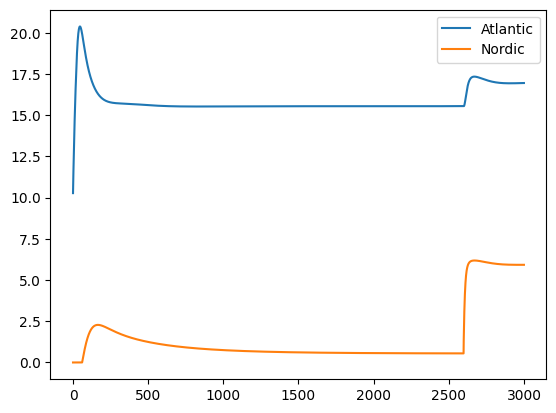

In [7]:
T_star_fit =[ 2.42760678e+00,  2.43805682e+01, -2.25133472e+00, -1.90342861e+00,-1.31888407e-03,  3.76682436e-02,  1.83669728e+01,  5.83439186e+00]

F = [-0.09/fact,0.07/fact,0.02/fact] 

T_fit,S_fit,m_fit,c_fit = model_diffusion(T_star_fit ,F,0,0)

print(c_fit[0,-1:], c_fit[1,-1:])
plt.plot(t[:-1],fact*m_fit[0,:len(t)-1], label = "Atlantic")
plt.plot(t[:-1],fact*m_fit[1,:len(t)-1], label = "Nordic")

plt.legend()
print("Southern:", T_fit[0,len(T_fit[0,:])-2], S_fit[0,len(T_fit[0,:])-2])
print("Tropical Surface:" ,T_fit[1,len(T_fit[0,:])-2], S_fit[1,len(T_fit[0,:])-2])
print("Northern Surface:" ,T_fit[2,len(T[0,:])-2], S_fit[2,len(T[0,:])-2])
print("Nordic Surface:" ,T_fit[3,len(T[0,:])-2], S_fit[3,len(T[0,:])-2])
print("Nordic Deep:" ,T_fit[4,len(T[0,:])-2], S_fit[4,len(T[0,:])-2])
print("Northern Deep:" ,T_fit[5,len(T[0,:])-2], S_fit[5,len(T[0,:])-2])
print("tropics Deep:" ,T_fit[6,len(T[0,:])-2], S_fit[6,len(T[0,:])-2])
print("tropics intermediate:" ,T_fit[7,len(T[0,:])-2], S_fit[7,len(T[0,:])-2])
print("Overturning:", m_fit[0,len(T[0,:])-2]*fact,m_fit[1,len(T[0,:])-2]*fact)

## Generate Hysteresis

In [97]:
traj = 350 #length of trajectory
F = [-0.09/fact,0.07/fact,0.02/fact] #initial freshwater fluxes 

T_star = np.array(T_star_fit)

#arrays for hysteresis 
c0 = np.zeros(traj) 
c1 = np.zeros(traj) 
moc = np.zeros(traj)
nmoc = np.zeros(traj)
T_hys = np.zeros((8,traj))
S_hys = np.zeros((8,traj))
Wr_hys = np.zeros((4,traj))
c = np.zeros((2,len(t)))+0.3

yrs = 1
t, dt = np.linspace(0,yrs,yrs*10, retstep = True) #timeline


ds = 0.000/fact/yrs*dt #incremental increase of F[1] per time step (mSV)
dT = 0.04/yrs*dt #incremental increase of T* per time step (degrees Celsius)
T = np.zeros((8,len(t))) 
S = np.zeros((8, len(t)))
S[:,0] = [34.64,36.29,34.38,34.34,34.88,34.88,34.92,35.02]

T[:,0] = T_fit[:,len(T_fit[0,:])-2]
S[:,0] = S_fit[:,len(T_fit[0,:])-2]

0.1111111111111111


In [98]:
#calc
for i in range(traj):
    T_hys[:,i],S_hys[:,i],moc[i],nmoc[i],c0[i],c1[i],F,T_star,Wr_hys[:,i] = model_diffusion(T_star, F,ds,dT)
    T[:,0] = T_hys[:,i]
    S[:,0] = S_hys[:,i]
    c[0,0] = c0[i]
    c[1,0] = c1[i]